In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
def get_data():
    X = pd.read_csv('X.csv', header = None, prefix = 'X')
    Y = pd.read_csv('Y.csv', names = ['Y'])
    return X, Y

In [3]:
def group_data(Y):
    # copy raw data
    df = Y.copy()
    
    # separate data into 10 groups, only store index
    group_size = df.shape[0]//10
    group = []
    for i in range(10):
        subset = df.sample(n = group_size, random_state = 1)
        group.append(subset.index)
        df.drop(subset.index, inplace = True)
        
    return group

In [4]:
def confusion_matrix(Y, Y_h):
    TP, TN, FP, FN = 0, 0, 0, 0
    for y, y_h in zip(Y, Y_h):
        if y == y_h == 1:
            TP += 1
        elif y == y_h == 0:
            TN += 1
        elif y == 0:
            FP += 1
        else:
            FN += 1
    return TP, TN, FP, FN

In [5]:
def naive_bayes(X_train, Y_train, X_test, Y_test):
    # pi mle
    pi_mle = (np.sum(Y_train['Y']) / len(Y_train))
    # lambda 0 mle
    lambda_0_mle = ((np.sum(X_train[Y_train['Y'] == 0], axis = 0) + 1) / 
                    (np.sum(Y_train['Y'] == 0) + 1))
    # lambda 1 mle
    lambda_1_mle = ((np.sum(X_train[Y_train['Y'] == 1], axis = 0) + 1) / 
                    (np.sum(Y_train['Y'] == 1) + 1))
    # predict
    # fixed, take log and ignore shared term fact(x)
    Y_pred = np.greater(
        np.log(pi_mle)   + np.sum(
            np.multiply(X_test.values,np.log(lambda_1_mle.values))-lambda_1_mle.values,axis =1),
        np.log(1-pi_mle) + np.sum(
            np.multiply(X_test.values,np.log(lambda_0_mle.values))-lambda_0_mle.values ,axis =1)
                       ).astype(int)

    # confusion matrix
    TP, TN, FP, FN = confusion_matrix(Y_test.values, Y_pred)
    return TP, TN, FP, FN, lambda_0_mle, lambda_1_mle

In [6]:
def problem_a(X,Y, group):
    TP, TN, FP, FN = 0, 0, 0, 0
    for i in range(10):
        (TP_tmp , TN_tmp, FP_tmp, FN_tmp, 
         lambda_0_tmp, lambda_1_tmp) = naive_bayes(
                        X.iloc[~X.index.isin(group[i])], 
                        Y.iloc[~Y.index.isin(group[i])],
                        X.iloc[X.index.isin(group[i])],
                        Y.iloc[Y.index.isin(group[i])])
        # accumulate confusion matrix result
        TP += TP_tmp 
        TN += TN_tmp
        FP += FP_tmp
        FN += FN_tmp
        # lambda
        try:
            lambda_0 += lambda_0_tmp
            lambda_1 += lambda_1_tmp
        except:
            lambda_0 = lambda_0_tmp.copy()
            lambda_1 = lambda_1_tmp.copy()
        # check    
    assert TP+TN+FP+FN == 4600

    print('Confusion Matrix after 10 cross validation')
    print('\tTrue\tFalse')
    print('Predict\t' + str(TP) + '\t' + str(FP))
    print('Predict\t' + str(FN) + '\t' + str(TN))
    print()
    print('Accuracy: ' + str((TP+TN)/len(Y)) + '\n')
    
    return lambda_0/10, lambda_1/10

In [7]:
def problem_b(lambda_0, lambda_1):
    fig = plt.figure(figsize=(12,6))
    _ = plt.stem(lambda_0, markerfmt  = 'C0o', linefmt = 'C0--', label = r"$\lambda_0$")
    _ = plt.stem(lambda_1, markerfmt  = 'C1o', linefmt = 'C1-.',label = r"$\lambda_1$")
    _ = plt.legend(fontsize=18)
    _ = plt.xlabel('Feature index', fontsize=18)
    _ = plt.ylabel(r"Average $\lambda$ value" ,fontsize=18)
    _ = plt.title('Problem 2 (b)',fontsize=20)
    _ = plt.xticks(np.arange(0, len(lambda_0)+1,5), fontsize=14)
    plt.savefig('problem_b.png')

In [8]:
def kNN(k, X_train, Y_train, X_test, Y_test):
    # accuracy
    accuracy = np.array([0] * 20)
    # initiate prediction 
    Y_pred = np.full((Y_test.shape[0],k), np.nan)
    # kNN model
    for i in range(Y_test.shape[0]):
        # calculate l1 distance
        dist = np.sum(np.abs(X_train - X_test.iloc[i,:]), axis = 1)
        top_k = dist.sort_values(ascending = True).index
        # prediction
        for j in range(0,k):
            Y_pred[i][j] = np.round(np.mean(Y_train[Y_train.index.isin(top_k[:j+1])]))
    for j in range(k):
        TP, TN, FP, FN = confusion_matrix(Y_test.values, Y_pred[:,j])
        assert TP+TN+FP+FN == 460
        accuracy[j] = (TP+TN)
    return accuracy

In [9]:
def problem_c(X,Y, group):
    TP, TN, FP, FN = 0, 0, 0, 0
    accuracy = np.array([0] * 20)
    for i in range(10):
        accuracy_tmp = kNN(20,
                       X.iloc[~X.index.isin(group[i])], 
                       Y.iloc[~Y.index.isin(group[i])],
                       X.iloc[X.index.isin(group[i])],
                       Y.iloc[Y.index.isin(group[i])])
        accuracy = accuracy + accuracy_tmp
    accuracy = accuracy / 4600
    # make plot
    fig = plt.figure(figsize=(8,6))
    x_index = [k for k in range(1,21)]
    _ = sns.lineplot(x_index, accuracy)
    _ = sns.scatterplot(x_index, accuracy)
    _ = plt.xticks(np.arange(0, 21, 5), fontsize=14)
    _ = plt.title('Problem 2 (c)', fontsize=20)
    _ = plt.xlabel('k', fontsize=18)
    _ = plt.ylabel('Accuracy', fontsize=18)
    plt.savefig('problem_c.png')

In [10]:
def confusion_matrix_(Y, Y_h):
    TP, TN, FP, FN = 0, 0, 0, 0
    for y, y_h in zip(Y, Y_h):
        if y == y_h == 1:
            TP += 1
        elif y == y_h == -1:
            TN += 1
        elif y == -1:
            FP += 1
        else:
            FN += 1
    return TP, TN, FP, FN

In [11]:
def logistic(X_train, Y_train, X_test, Y_test, newton = False):
    # initialize w
    w = np.full(X_train.shape[1],0.0).reshape(-1,1)
    # ita
    ita = 0.01/4600
    # Loss
    loss = np.full(100, 0.0) if newton else np.full(1000,0.0)
    # iteration
    iters = 100 if newton else 1000
    for i in range(iters):
        # sigma (y dot w)
        #sigma = np.exp( Y_train.values * X_train.values.dot(w) )
        sigma = np.exp(np.multiply(Y_train.values, X_train.values.dot(w)))
        sigma = np.divide(sigma, 1 + sigma )
        # loss
        loss[i] = np.sum(np.log(sigma))
        # 1st order gradient
        gradient = np.sum(np.multiply((1-sigma), (Y_train.values * X_train.values)), axis = 0)
        # 2nd order gradient for Newton method
        sec_grad = -(np.multiply(sigma,(1-sigma)) * X_train).T.dot(X_train) 
        # update
        if ~newton:
            w += ita * gradient.reshape(gradient.shape[0],1)
        else:
            w -= ita * np.linalg.inv(sec_grad).dot(gradient)
            
    # prediction
    if newton:
        Y_pred = np.sign(X_test.dot(w))
        TP, TN, FP, FN = confusion_matrix_(Y_test.values, Y_pred.values.astype(int))
        return (loss, TP, TN, FP, FN)
    else:
        return loss

In [12]:
def problem_d(X, Y, group):
    loss = []
    for i in range(10):
        loss.append(logistic(X.iloc[~X.index.isin(group[i])],
                        Y.iloc[~Y.index.isin(group[i])],
                        X.iloc[X.index.isin(group[i])],
                        Y.iloc[Y.index.isin(group[i])]))
    # making plot
    fig = plt.figure(figsize=(8,6))
    x_index = [k for k in range(1,1001)]
    for i in range(10):
        _ = sns.lineplot(x = x_index, y = loss[i], label = 'Run' + str(i+1))
    _ = plt.title('Problem (d)', fontsize = 20)
    _ = plt.xlabel('Iteration', fontsize = 18)
    _ = plt.ylabel('Loss', fontsize = 18)
    _ = plt.legend(fontsize = 14)
    plt.savefig('problem_d.png')

In [13]:
def problem_e(X, Y, group):
    loss = []
    TP, TN, FP, FN = 0, 0, 0, 0
    for i in range(10):
        tmp, TP_, TN_, FP_, FN_ = logistic(
                        X.iloc[~X.index.isin(group[i])],
                        Y.iloc[~Y.index.isin(group[i])],
                        X.iloc[X.index.isin(group[i])],
                        Y.iloc[Y.index.isin(group[i])],
                        True)
        loss.append(tmp)
        TP += TP_
        TN += TN_
        FP += FP_
        FN += FN_
    assert TP+TN+FP+FN == 4600
    # making plot
    fig = plt.figure(figsize=(8,6))
    x_index = [k for k in range(1,101)]
    for i in range(10):
        _ = sns.lineplot(x = x_index, y = loss[i], label = 'Run' + str(i+1))
    _ = plt.title('Problem (e)', fontsize = 20)
    _ = plt.xlabel('Iteration', fontsize = 18)
    _ = plt.ylabel('Loss', fontsize = 18)
    _ = plt.legend(fontsize = 14)
    plt.savefig('problem_e.png')
    
    # confusion matrix
    print('Problem (f)')
    print('Confusion Matrix after 10 cross validation')
    print('\tTrue\tFalse')
    print('Predict\t' + str(TP) + '\t' + str(FP))
    print('Predict\t' + str(FN) + '\t' + str(TN))
    print()
    print('Accuracy: ' + str((TP+TN)/len(Y)))

In [14]:
def main():
    # read data
    X, Y = get_data()
    # grouping list
    group = group_data(Y)
    # problem a
    print('Problem a')
    lambda_0, lambda_1 = problem_a(X,Y,group)
    # problem b
    print('Problem b\n')
    problem_b(lambda_0, lambda_1)
    # problem c
    print('Problem c\n')
    problem_c(X, Y, group)
    # modify for logistic regresssion
    X_, Y_ = X.copy(), Y.copy()
    Y_[Y_==0] = -1
    X_.insert(loc = 0, column = 'C', value = np.full(X.shape[0],1) )
    # problem d
    print('Problem d\n')
    problem_d(X_, Y_, group)
    # problem e & f
    print('Problem e & f')
    problem_e(X_, Y_, group)

Problem a
Confusion Matrix after 10 cross validation
	True	False
Predict	1714	490
Predict	99	2297

Accuracy: 0.8719565217391304

Problem b

Problem c

Problem d

Problem e & f
Problem (f)
Confusion Matrix after 10 cross validation
	True	False
Predict	1654	213
Predict	159	2574

Accuracy: 0.9191304347826087


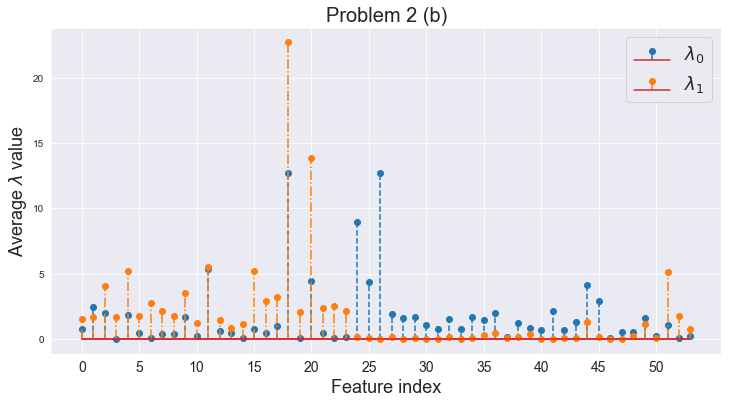

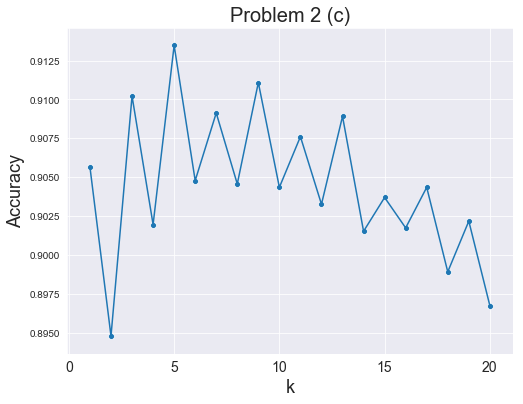

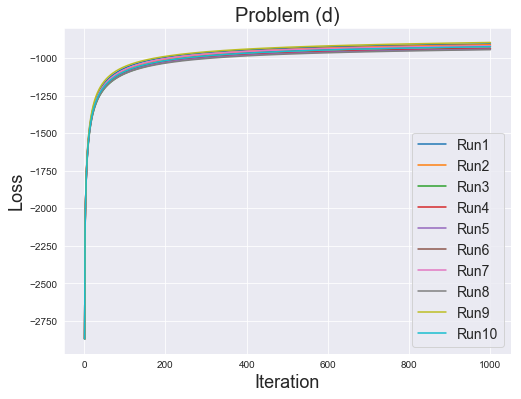

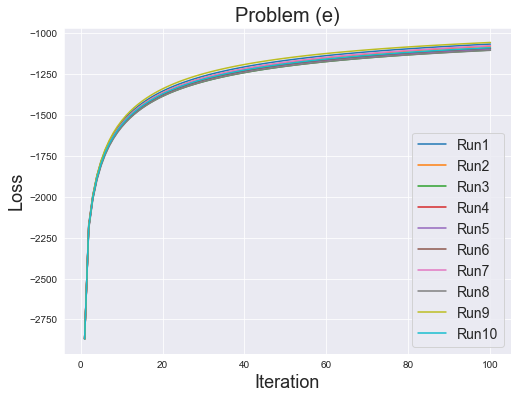

In [15]:
if __name__ == "__main__":
	main()